# Variational Autoencoder for Regression - WIP

- Paper https://arxiv.org/abs/1904.05948

- Repository https://github.com/QingyuZhao/VAE-for-Regression


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Example Data

In [3]:
# Load Toy Example Data
training_feature = np.loadtxt('data/X.txt')
training_feature.shape

Y = np.loadtxt('data/Y.txt')
ground_truth_r = Y

np.random.seed(seed=0)

original_dim = training_feature.shape[1]
num_train = training_feature.shape[0]

In [4]:
def sampling(mean, log_var):
    '''
    Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    Returns:
        z (tensor): sampled latent vector
    '''
    #print(type(mean), type(log_var))
    epsilon = torch.randn_like(mean) 
    return mean + torch.exp(0.5*log_var)*epsilon 

## Build VAE Regression Model 

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_shape_x, intermediate_dim, latent_dim):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(input_shape_x, 128)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(128, intermediate_dim)
        self.act2 = nn.Tanh() 
        
        # posterior on Y; probabilistic regressor 
        self.r_mean_layer = nn.Linear(intermediate_dim, 1)
        self.r_logvar_layer = nn.Linear(intermediate_dim, 1) 

        # q(z|x) 
        self.z_mean_layer = nn.Linear(intermediate_dim, latent_dim)
        self.z_logvar_layer = nn.Linear(intermediate_dim, latent_dim)

        # latent generator 
        self.gen_z = weight_norm(nn.Linear(1, latent_dim))


    def forward(self, x):
        x = self.dropout(x)
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))

        r_mean = self.r_mean_layer(x)
        r_logvar = self.r_logvar_layer(x)

        z_mean = self.z_mean_layer(x)
        z_logvar = self.z_logvar_layer(x)
                
        # reparameterization trick
        r = sampling(r_mean, r_logvar)
        z = sampling(z_mean, z_logvar)

        pz_mean = self.gen_z(r) 

        return r_mean, r_logvar, r, z_mean, z_logvar, z, pz_mean


In [6]:
class Decoder(nn.Module):
    def __init__(self, input_shape_x, intermediate_dim, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, intermediate_dim)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(intermediate_dim, 128)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(128, input_shape_x)

    
    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.fc3(x)
        return x 

## Dataset 

In [7]:
class VAEDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.Tensor(images)
        self.labels = torch.Tensor(labels) 
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        imgs = self.images[idx]
        lbls = self.labels[idx]
        return imgs, lbls 

## Hyperparameters

In [8]:

intermidiate_dim = 32
batch_size = 64
latent_dim = 8
epochs = 100
lr = 0.001
mse = nn.MSELoss()

## Loss Function

In [9]:
def loss_function(inputs_x, outputs, inputs_r, r_mean, r_logvar, z_mean, z_log_var,  pz_mean):
    
    reconstruction_loss = mse(inputs_x, outputs)
    kl_loss = 1 + z_logvar - torch.square(z_mean - pz_mean) - torch.exp(z_logvar)
    kl_loss = -0.5 * torch.sum(kl_loss) 
        
    label_loss = torch.divide(0.5 * torch.square(r_mean - inputs_r), torch.exp(r_logvar)) +  0.5 * r_logvar
    return torch.mean(reconstruction_loss + kl_loss + label_loss)

In [10]:
print('Number of records:', len(ground_truth_r)) 
ground_truth_r = np.array(ground_truth_r).reshape(-1, 1)

Number of records: 245


## Training

In [11]:

np.random.seed(0)
skf = StratifiedKFold(n_splits=10)
pred = np.zeros((ground_truth_r.shape))
fake = np.zeros((ground_truth_r.shape[0]))
fake[:300] = 1


# Run 10-fold CV
for train_idx, test_idx in skf.split(training_feature, fake):
    
    encoder = Encoder(original_dim, 32, 8).to(device)
    decoder = Decoder(original_dim, 32, 8).to(device)     
    
    optim_params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(optim_params , lr=lr)
    
    training_feature_sk = training_feature[train_idx,:]
    training_score = ground_truth_r[train_idx]
    testing_feature_sk = training_feature[test_idx,:]
    testing_score = ground_truth_r[test_idx]    
    
    train = VAEDataset(training_feature_sk, training_score)
    test = VAEDataset(testing_feature_sk, testing_score)
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True) 
    test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=False)     
    
    for epoch in range(epochs):
        
        for idx, data in enumerate(train_dataloader):
        
            imgs, labels = data
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            r_mean, r_logvar, r, z_mean, z_logvar, z, pz_mean = encoder(imgs) 
            
            recon_imgs = decoder(z)
            
            #print(r_mean.shape, labels.shape)
            
            vae_loss = loss_function(imgs, recon_imgs, labels, r_mean, r_logvar, z_mean, z_logvar, pz_mean)
            
            optimizer.zero_grad()
            
            vae_loss.backward()
            
            optimizer.step()
            
        with torch.no_grad():

            x = torch.Tensor(testing_feature_sk).to(device)
            r_mean, r_logvar, r, z_mean, z_logvar, z, pz_mean = encoder(x)

            pred[test_idx] = r_mean.cpu().detach()
            rmse_loss = np.sqrt(mse(r_mean.cpu().detach(), torch.Tensor(testing_score)))
            
            if epoch % 10 == 0:
            
                print(f'Epoch: {epoch}    VAE Loss: {vae_loss}    RMSE Loss: {rmse_loss}')
            

Epoch: 0    VAE Loss: 70.40030670166016    RMSE Loss: 1.1411375999450684
Epoch: 10    VAE Loss: 33.626068115234375    RMSE Loss: 1.0750170946121216
Epoch: 20    VAE Loss: 10.626846313476562    RMSE Loss: 1.0985153913497925
Epoch: 30    VAE Loss: 7.141457557678223    RMSE Loss: 0.9973481893539429
Epoch: 40    VAE Loss: 7.111352443695068    RMSE Loss: 0.8620398640632629
Epoch: 50    VAE Loss: 4.480567932128906    RMSE Loss: 0.7260765433311462
Epoch: 60    VAE Loss: 3.979712963104248    RMSE Loss: 0.6041503548622131
Epoch: 70    VAE Loss: 3.064650058746338    RMSE Loss: 0.543070912361145
Epoch: 80    VAE Loss: 2.956231117248535    RMSE Loss: 0.5351529121398926
Epoch: 90    VAE Loss: 2.1602466106414795    RMSE Loss: 0.4720814824104309
Epoch: 0    VAE Loss: 38.35383987426758    RMSE Loss: 1.4672297239303589
Epoch: 10    VAE Loss: 11.623821258544922    RMSE Loss: 1.177492618560791
Epoch: 20    VAE Loss: 5.817833423614502    RMSE Loss: 1.0637483596801758
Epoch: 30    VAE Loss: 4.1408305168151

## Validation

Mean squared error: 0.356
R2 Variance score: 0.643


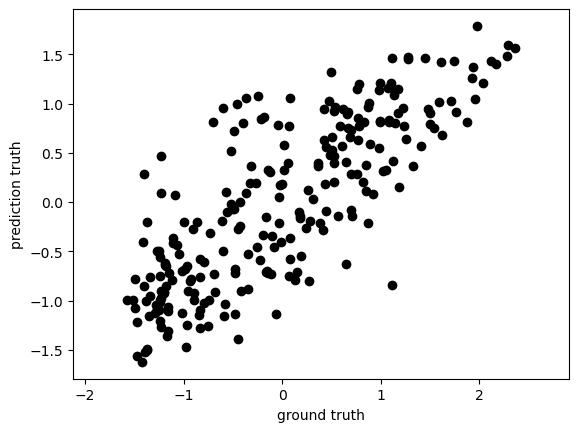

In [12]:
# Mean squared error
print("Mean squared error: %.3f" % mean_squared_error(ground_truth_r, pred))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(ground_truth_r, pred))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(ground_truth_r, pred,  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

## Visualize Latent Space


In [13]:
r_mean, r_logvar, r, z_mean, z_logvar, z, pz_mean = encoder(torch.Tensor(training_feature).to(device)) 

(-1.9420855222103264,
 2.3490125651986014,
 -1.2339972103792924,
 0.7827501132582452)

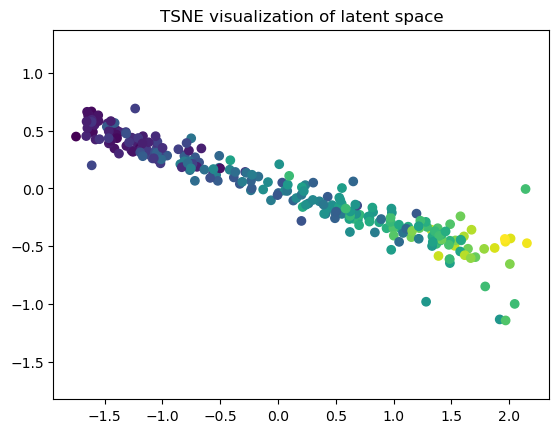

In [14]:

tsne = MDS(n_components=2, random_state=0)
X_2d = tsne.fit_transform(z_mean.cpu().detach())

#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X_2d[:, 0], X_2d[:, 1], c=ground_truth_r)
plt.title('TSNE visualization of latent space')
ax.axis('equal')


## Reference

- https://github.com/yoonsanghyu/VAE_for_regression_PyTorch